Current working directory has been set to: C:\Users\Buboy\Downloads

Starting data processing pipeline...
Successfully loaded file: customer_demographics_contaminated.csv
Successfully loaded file: social_media_interactions_contaminated.csv
Successfully loaded file: customer_transactions_contaminated.csv
Loaded and merged dataframe shape: (6589, 16)
Converted date columns.


C:\Users\Buboy\AppData\Local\Temp\ipykernel_17780\3276621573.py:159: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=infer)
C:\Users\Buboy\AppData\Local\Temp\ipykernel_17780\3276621573.py:159: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=infer)
C:\Users\Buboy\AppData\Local\Temp\ipykernel_17780\3276621573.py:159: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A stri

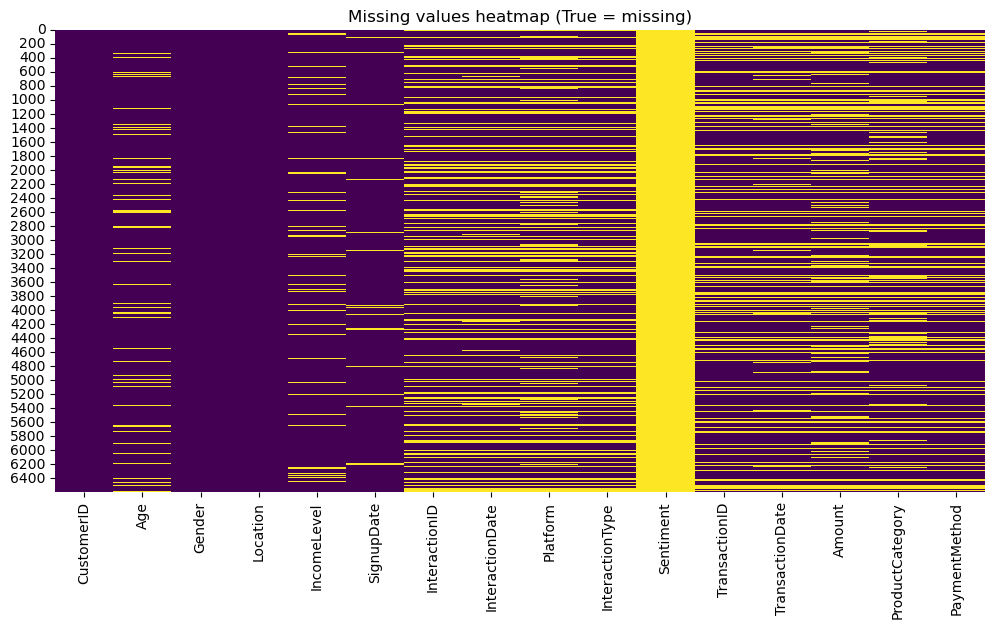

Generated missing values heatmap and saved as 'missing_values_heatmap.png'.
Categorical modes used: {'CustomerID': '473f3b1f-2e0e-40a6-8917-b3aac5296a01', 'Gender': 'Female', 'Location': 'West David', 'IncomeLevel': 'High', 'InteractionID': '83975da0-a803-448e-917a-7db7464f8c61', 'Platform': 'Instagram', 'InteractionType': 'Share', 'TransactionID': 'e432cee0-d280-4f2e-b520-fab4bdb2dd31', 'ProductCategory': 'Electronics', 'PaymentMethod': 'Debit Card'}
Numeric imputes used (median): {'Age': 45.0, 'Amount': 504.66499999999996}
Outlier counts per numeric column (IQR method):
  Age: 63
  Amount: 232
Capped outliers in numeric columns.
Removed 3589 duplicate rows based on TransactionID.
One-hot encoded (binary) columns: ['Gender']
Label encoded columns (created ..._label): ['CustomerID', 'Location', 'IncomeLevel', 'InteractionID', 'Platform', 'InteractionType', 'TransactionID', 'ProductCategory', 'PaymentMethod']
Categorical features have been encoded.
Created normalized and standardized ve

In [1]:
import os
from typing import List, Dict, Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Working directory
try:
    os.chdir("C:\\Users\\Buboy\\Downloads\\")
    working_directory = os.getcwd()
    print(f"Current working directory has been set to: {working_directory}\n")
except FileNotFoundError:
    print(f"Error: The specified directory was not found. Please ensure that 'C:\\Users\\Buboy\\Downloads\\' is the correct path.\n")
    # Exit or continue with caution
    exit()


# Utility: find likely customer id column names in a df
def find_customer_id_col(df: pd.DataFrame) -> Optional[str]:
    candidates = [
        c
        for c in df.columns
        if c.lower()
        in ("customerid", "customer_id", "customer", "id", "customerid", "customer id")
    ]
    return candidates[0] if candidates else None


#  Merge multiple CSVs into single DataFrame on customer_id-like column ---
def load_and_merge_csvs(
    csv_paths: List[str], merge_on: Optional[str] = None, how: str = "outer"
) -> pd.DataFrame:
    """
    Load multiple CSVs and merge on customer_id. If merge_on is None,
    attempts to detect common 'customer_id' column name in the files.
    """
    dfs = []
    for p in csv_paths:
        try:
            df = pd.read_csv(p, dtype=str)  # read as str first to avoid type surprises
            df.columns = [c.strip() for c in df.columns]
            dfs.append(df)
            print(f"Successfully loaded file: {os.path.basename(p)}")
        except FileNotFoundError:
            print(f"Error: The file {os.path.basename(p)} was not found. Please check the file path.")
            return None # Exit if a file is not found
    
    if not dfs:
        return None
        
    # detect merge_on if not given
    if merge_on is None:
        # pick first df and find a candidate, or check intersection across files
        candidates = []
        for df in dfs:
            col = find_customer_id_col(df)
            if col:
                candidates.append(col)
        merge_on = candidates[0] if candidates else None
    if merge_on is None:
        raise ValueError(
            "Couldn't detect a customer id column automatically. Pass merge_on explicitly."
        )
    # standardize column name across dfs
    for i, df in enumerate(dfs):
        found = None
        for col in df.columns:
            if col.lower() == merge_on.lower():
                found = col
                break
        if found and found != merge_on:
            dfs[i] = df.rename(columns={found: merge_on})
    # merge sequentially
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on=merge_on, how=how)
    # try to coerce numeric columns to numeric where sensible
    for col in merged.columns:
        # skip customer id
        if col == merge_on:
            continue
        # try numeric
        coerced = pd.to_numeric(merged[col], errors="coerce")
        # if at least half non-null numeric, keep numeric
        if coerced.notnull().sum() >= merged.shape[0] * 0.5:
            merged[col] = coerced
    return merged


# Missing datapoints detection via heatmap ---
def plot_missing_heatmap(df: pd.DataFrame, figsize=(12, 6), cmap="viridis"):
    """Plot missingness heatmap (True = missing)."""
    plt.figure(figsize=figsize)
    sns.heatmap(df.isnull(), cbar=False, cmap=cmap)
    plt.title("Missing values heatmap (True = missing)")
    plt.savefig("missing_values_heatmap.png")
    plt.show()


# Imputation helpers ---
def impute_categorical_mode(
    df: pd.DataFrame, categorical_cols: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """Mode imputation for categorical/object columns. Returns df and dict of used modes."""
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    modes = {}
    for c in categorical_cols:
        mode_val = df[c].mode(dropna=True)
        if len(mode_val) > 0:
            fill = mode_val.iloc[0]
        else:
            fill = "UNKNOWN"
        df[c] = df[c].fillna(fill)
        modes[c] = fill
    return df, modes


def impute_numeric(
    df: pd.DataFrame, numeric_cols: Optional[List[str]] = None, method: str = "mean"
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Impute numeric columns with method in ('mean','median').
    Returns df and dict of imputed values.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    imputed = {}
    for c in numeric_cols:
        if method == "mean":
            val = df[c].mean(skipna=True)
        elif method == "median":
            val = df[c].median(skipna=True)
        else:
            raise ValueError("method must be 'mean' or 'median'")
        df[c] = df[c].fillna(val)
        imputed[c] = val
    return df, imputed


def convert_to_datetime(
    df: pd.DataFrame, date_cols: Optional[List[str]] = None, infer: bool = True
) -> pd.DataFrame:
    """Convert candidate columns to datetime (coerce errors to NaT). If date_cols None, auto-detect those with 'date' in name."""
    if date_cols is None:
        date_cols = [c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=infer)
    return df


def cap_outliers_iqr_series(
    s: pd.Series, k: float = 1.5
) -> Tuple[pd.Series, float, float]:
    """Cap series using IQR rule. Returns (capped_series, lower_cap, upper_cap)."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    s_capped = s.clip(lower=lower, upper=upper)
    return s_capped, lower, upper


def winsorize_series_pct(
    s: pd.Series, lower_pct: float = 0.01, upper_pct: float = 0.01
) -> pd.Series:
    """Winsorize series using given lower/upper fraction (e.g., 0.01 -> 1%)."""
    # winsorize from scipy expects limits=(lower, upper) where each is fraction to cut.
    # But it works on numpy arrays; preserve index
    arr = s.to_numpy(dtype=float)
    arr_w = winsorize(arr, limits=(lower_pct, upper_pct))
    return pd.Series(arr_w, index=s.index)


# --- 4) Outlier detection for numeric features ---
def detect_outliers(
    df: pd.DataFrame,
    numeric_cols: Optional[List[str]] = None,
    method: str = "iqr",
    z_thresh: float = 3.0,
    iqr_k: float = 1.5,
) -> Dict[str, np.ndarray]:
    """
    Returns dict: column -> numpy array of indices (row indices) flagged as outliers.
    method: 'iqr' or 'zscore'
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outliers = {}
    for c in numeric_cols:
        s = df[c].dropna()
        if method == "zscore":
            z = np.abs(stats.zscore(s))
            flagged = s.index[z > z_thresh].to_numpy()
        else:  # default iqr
            q1 = s.quantile(0.25)
            q3 = s.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_k * iqr
            upper = q3 + iqr_k * iqr
            flagged = s.index[(s < lower) | (s > upper)].to_numpy()
        outliers[c] = flagged
    return outliers


# Duplicate removal ---
def remove_duplicates(
    df: pd.DataFrame, subset: Optional[List[str]] = None, keep: str = "first"
) -> Tuple[pd.DataFrame, int]:
    """
    Removes duplicate rows. If subset None, dedup on all columns.
    Returns (deduped_df, number_removed).
    """
    before = df.shape[0]
    df2 = df.drop_duplicates(subset=subset, keep=keep)
    removed = before - df2.shape[0]
    return df2, removed


# Encoding + reverse encoding ---
class CategoricalEncoder:
    def __init__(self):
        self.label_encoders: Dict[str, LabelEncoder] = {}
        self.one_hot_columns: List[str] = []

    def fit_label(self, df: pd.DataFrame, cols: List[str]):
        for c in cols:
            le = LabelEncoder()
            # fillna temporarily to allow fitting
            arr = df[c].astype(str).fillna("@@MISSING@@")
            le.fit(arr)
            self.label_encoders[c] = le

    def transform_label(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        for c, le in self.label_encoders.items():
            df[c + "_label"] = le.transform(df[c].astype(str).fillna("@@MISSING@@"))
        return df

    def inverse_transform_label(
        self, df: pd.DataFrame, label_cols: Optional[List[str]] = None
    ) -> pd.DataFrame:
        df = df.copy()
        if label_cols is None:
            label_cols = [c + "_label" for c in self.label_encoders.keys()]
        for c_label in label_cols:
            orig = c_label.replace("_label", "")
            if orig in self.label_encoders:
                le = self.label_encoders[orig]
                df[orig + "_decoded"] = le.inverse_transform(df[c_label].astype(int))
        return df

    def one_hot_encode(
        self, df: pd.DataFrame, cols: List[str], drop_first: bool = True
    ) -> pd.DataFrame:
        """One-hot encode listed columns. Returns new df and stores created columns."""
        df_new = pd.get_dummies(
            df, columns=cols, drop_first=drop_first, dummy_na=False
        )
        # store names if needed
        self.one_hot_columns = [
            c for c in df_new.columns if any(col + "_" in c for col in cols)
        ]
        return df_new


# Transformation for numeric features ---
def normalize_columns(
    df: pd.DataFrame, cols: List[str]
) -> Tuple[pd.DataFrame, MinMaxScaler]:
    scaler = MinMaxScaler()
    df_copy = df.copy()
    df_copy[cols] = scaler.fit_transform(df_copy[cols].astype(float))
    return df_copy, scaler


def standardize_columns(
    df: pd.DataFrame, cols: List[str]
) -> Tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df_copy = df.copy()
    df_copy[cols] = scaler.fit_transform(df_copy[cols].astype(float))
    return df_copy, scaler


# Example pipeline using the above helpers 
def example_pipeline(csv_paths: List[str], merge_on: Optional[str] = None):
    print("Starting data processing pipeline...")
    
    # 1. Load & merge
    df = load_and_merge_csvs(csv_paths, merge_on=merge_on, how="outer")
    if df is None:
        print("Data loading failed. Exiting pipeline.")
        return
    print(f"Loaded and merged dataframe shape: {df.shape}")

    # 2. Convert date-like cols
    df = convert_to_datetime(df)
    print("Converted date columns.")

    # 3. Show missingness heatmap
    plot_missing_heatmap(df)
    print("Generated missing values heatmap and saved as 'missing_values_heatmap.png'.")

    # 4. Impute categorical by mode
    df, cat_modes = impute_categorical_mode(df)
    print("Categorical modes used:", cat_modes)

    # 5. Impute numeric by median (safer with skew)
    df, numeric_imputes = impute_numeric(df, method="median")
    print("Numeric imputes used (median):", numeric_imputes)

    # 6. Detect numeric outliers (IQR)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outliers = detect_outliers(df, numeric_cols, method="iqr")
    print("Outlier counts per numeric column (IQR method):")
    for k, v in outliers.items():
        print(f"  {k}: {len(v)}")

    # 7. Cap extreme numeric outliers via IQR capping
    for c in numeric_cols:
        df[c], lower_cap, upper_cap = cap_outliers_iqr_series(df[c].astype(float), k=1.5)
    print("Capped outliers in numeric columns.")

    # 8. Remove duplicates based on TransactionID
    if "TransactionID" in df.columns:
        before = df.shape[0]
        df, removed = remove_duplicates(df, subset=["TransactionID"], keep="first")
        print(f"Removed {removed} duplicate rows based on TransactionID.")
    else:
        print("Warning: TransactionID column not found. No duplicates removed.")

    # 9. Encoding
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    binary_cols = [c for c in cat_cols if df[c].nunique(dropna=True) == 2]
    multi_cat_cols = [c for c in cat_cols if c not in binary_cols]

    encoder = CategoricalEncoder()
    if binary_cols:
        df = encoder.one_hot_encode(df, binary_cols, drop_first=False)
        print("One-hot encoded (binary) columns:", binary_cols)

    if multi_cat_cols:
        encoder.fit_label(df, multi_cat_cols)
        df = encoder.transform_label(df)
        print("Label encoded columns (created ..._label):", multi_cat_cols)
    print("Categorical features have been encoded.")

    # 10. Transform numeric columns (standardize and normalize copies)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df_norm, norm_scaler = normalize_columns(df, numeric_cols)
    df_std, std_scaler = standardize_columns(df, numeric_cols)
    print("Created normalized and standardized versions of numeric features.")

    # Save the dataframes
    df.to_csv("cleaned_merged_data.csv", index=False)
    df_norm.to_csv("normalized_data.csv", index=False)
    df_std.to_csv("standardized_data.csv", index=False)
    print("\nData processing complete. Saved the following files:")
    print("- cleaned_merged_data.csv")
    print("- normalized_data.csv")
    print("- standardized_data.csv")

    # Return everything useful
    return {
        "raw": df,
        "normalized": df_norm,
        "standardized": df_std,
        "encoder": encoder,
        "numeric_imputes": numeric_imputes,
        "categorical_modes": cat_modes,
        "outliers": outliers,
        "norm_scaler": norm_scaler,
        "std_scaler": std_scaler,
    }


# Example usage
if __name__ == "__main__":
    csv_paths = [
        "C:\\Users\\Buboy\\Downloads\\customer_demographics_contaminated.csv",
        "C:\\Users\\Buboy\\Downloads\\social_media_interactions_contaminated.csv",
        "C:\\Users\\Buboy\\Downloads\\customer_transactions_contaminated.csv",
    ]
    result = example_pipeline(
        csv_paths, merge_on="CustomerID"
    )

    if result:
        # Access cleaned DataFrame
        df_clean = result["raw"]

        # Access normalized version
        df_norm = result["normalized"]

        # Access standardized version
        df_std = result["standardized"]

        print("\nFirst 5 rows of the final cleaned and merged DataFrame:")
        print(df_clean.head())